In [1]:
import mne 
import pickle
import argparse
import numpy as np
import os
import scipy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages 
from sklearn.utils import shuffle

from src.params import SUBJ_CLEAN, RESULT_PATH, ACTIVE_RUN, PASSIVE_RUN, FIG_PATH, FREQS_LIST, PREPROC_PATH, FREQS_NAMES
from src.utils import get_bids_file
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV, LeaveOneGroupOut, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from statsmodels.stats.multitest import fdrcorrection

from mpl_toolkits.axes_grid1 import make_axes_locatable


from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP,
)

In [2]:
def time_window_hilbert_one_su(subj_list, RUN_LIST, tmin, tmax, cond1, cond2, FREQS_NAMES, FREQS_LIST, save=True) :
    
    print('Time window : ' + str(tmin) + '-' + str(tmax))

    FREQS = [x for x in range(len(FREQS_LIST))]
    idx = 0 #TODO : Change that
    
    for l_freq, h_freq in FREQS_LIST :
        print('Processing freqs -->', l_freq, h_freq)
        
        for i_subj, subj in enumerate(subj_list):
            print("=> Process task :", task, 'subject', subj)
            
            epochs_list = []

            y_run_cond1 = []
            y_run_cond2 = []

            X_subj = []
            y_subj = []

            X_cond1 = []
            X_cond2 = []

            power_list = []
            
            group = []

            sub_id = 'sub-' + subj
            subj_path = os.path.join(RESULT_PATH, 'meg', 'reports', sub_id)

            if not os.path.isdir(subj_path):
                os.mkdir(subj_path)
                print('BEHAV folder created at : {}'.format(subj_path))
            else:
                print('{} already exists.'.format(subj_path))

            # Take ica data
            _, ica_path = get_bids_file(PREPROC_PATH, stage='ica', subj=subj)
            ica = mne.preprocessing.read_ica(ica_path)
        
            # Select rejection threshold associated with each run
            # TODO : apply threshold per run
            print('Load reject threshold')
            _, reject_path = get_bids_file(RESULT_PATH, stage="AR_epo", task=task, subj=subj, measure='log')

            with open(reject_path, 'rb') as f:
                reject = pickle.load(f)  

            # Select event_id appropriate
            for run in RUN_LIST :
                print("=> Process run :", run)
                        
                if task == 'LaughterPassive' :
                    if run == '02' or run == '03' :
                        event_id = {'LaughReal' : 11, 'LaughPosed' : 12, 'EnvReal' : 21, 
                                    'EnvPosed' : 22}
                    elif run == '04' or run == '05' :
                        event_id = {'LaughReal' : 11, 'LaughPosed' : 12,'ScraReal' : 31, 
                                    'ScraPosed' : 32,}
                if task == 'LaughterActive' :
                        event_id = {'LaughReal' : 11, 'LaughPosed' : 12, 'Good' : 99, 'Miss' : 66}


                # Take raw data filtered : i.e. NO ICA 
                print('ICA')
                _, raw_path = get_bids_file(PREPROC_PATH, stage='proc-filt_raw', task=task, run=run, subj=subj)
                raw = mne.io.read_raw_fif(raw_path, preload=True)
                raw_filter = raw.copy()
                raw_filter = ica.apply(raw_filter)

                epochs_psds = []

                freq_name = FREQS_NAMES[idx]

                print('Apply filter')
                info = raw_filter.info
                raw_filter.filter(l_freq, h_freq) # Apply filter of interest
                raw_hilbert = raw_filter.apply_hilbert(envelope=True)

                picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False)

                power_hilbert = raw_hilbert.copy()
                power_hilbert._data = power_hilbert._data**2

                # Segmentation
                print('Segmentation')
                events = mne.find_events(raw)
                epochs = mne.Epochs(
                    power_hilbert,
                    events=events,
                    event_id=event_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline=(tmin, tmin),
                    picks=picks)    

                # Auto-reject epochs
                epochs.drop_bad(reject=reject)

                if subj == subj_list[0] and run == run_list[0]:
                    head_info = epochs.info['dev_head_t']
                else:
                    epochs.info['dev_head_t'] = head_info

                epochs.equalize_event_counts([cond1, cond2])
                
                for i_cond, cond in enumerate(epochs[cond1, cond2].get_data()) : 
                    group.append(i_subj)
                    
                epochs_list.append(epochs)

                del epochs
                
            epochs_all_run = mne.concatenate_epochs(epochs_list)  

            print(epochs_all_run)

            # Compute power (= envelop **2)
            print('Calculte power')
            ave_time_cond1 = np.mean(epochs_all_run[cond1].get_data(), axis=2)
            ave_time_cond2 = np.mean(epochs_all_run[cond2].get_data(), axis=2)

            X_cond1.append(ave_time_cond1)
            X_cond2.append(ave_time_cond2)
            print('Cond1 shape :', X_cond1)
            print('Cond2 shape :', X_cond2)

            print('Concatenation')
            X_subj.append(np.concatenate((ave_time_cond1, ave_time_cond2)))
            y_subj.append(np.concatenate((epochs_all_run[cond1].events[:, 2], epochs_all_run[cond2].events[:, 2])))

            print(X_subj[-1].shape)
            print(y_subj[-1].shape)
            print(np.array(group).shape)
            
            # Classification
            all_scores = clf_randomSearch(X_subj, y_subj, group)
            print(all_scores)
            # Plot topomap per subject
            fig, ax_topo = plt.subplots(1, figsize=(10, 10))

            vmin = min(all_scores)
            vmax = max(all_scores)

            img, _ = mne.viz.plot_topomap(all_scores, epochs_all_run.info, axes=ax_topo, show=False, 
                                    cmap='plasma_r', extrapolate='head',
                                    sphere=(0, 0.0, 0, 0.19), vlim = (vmin, vmax))

            ax_topo.set_title(freq_name)
            
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(img, cax=cbar_ax)
            cbar_ax.set_label('Accuracy')
            
            plt.show()
    

            if save == True : 
                sub_name = subj
                run_name = 'all'
                tmin_name = str(int(tmin*1000))
                tmax_name = str(int(tmax*1000))
                stage = 'ml-'+ tmin_name + '-' + tmax_name
                conditions = cond1 + '-' + cond2

                save_X = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-{}_{}.pkl'.format(sub_name, task, 
                                                                                                    run_name, conditions,
                                                                                                    'X-subj', stage)
                save_y = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-{}_{}.pkl'.format(sub_name, task, 
                                                                                                    run_name, conditions,'y-subj', stage)

                save_group = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-{}_{}.pkl'.format(sub_name, task, 
                                                                                                    run_name, conditions,
                                                                                                    'group', stage)

                save_X1 = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-{}_{}.pkl'.format(sub_name, task, 
                                                                                                    run_name, conditions,
                                                                                                    'X-cond1', stage)

                save_X2 = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-{}_{}.pkl'.format(sub_name, task, 
                                                                                                    run_name, conditions,
                                                                                                    'X-cond2', stage)

                with open(save_X, 'wb') as f:
                    pickle.dump(X_subj, f)

                with open(save_y, 'wb') as f:
                    pickle.dump(y_subj, f)

                with open(save_group, 'wb') as f:
                    pickle.dump(group, f)

                with open(save_X1, 'wb') as f:
                    pickle.dump(X_cond1, f)

                with open(save_X2, 'wb') as f:
                    pickle.dump(X_cond2, f)

    return X_subj, y_subj, group, epochs_all_run, X_cond1, X_cond2

In [3]:
def upload_data(tmin, tmax, cond1, cond2, freq_name) : 
    sub_name = 'all'
    run_name = 'all'
    tmin_name = str(int(tmin*1000))
    tmax_name = str(int(tmax*1000))
    stage = 'ml-'+ tmin_name + '-' + tmax_name
    conditions = cond1 + '-' + cond2

    save_X = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-sf-{}_freq-{}_{}.pkl'.format(sub_name, task, 
                                                                                                        run_name, conditions,
                                                                                                        'X-subj', freq_name, stage)
    
    save_y = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-sf-{}_freq-{}_{}.pkl'.format(sub_name, task, 
                                                                                                        run_name, conditions,
                                                                                                        'y-subj', freq_name, stage)

    save_group = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-sf-{}_freq-{}_{}.pkl'.format(sub_name, task, 
                                                                                                            run_name, conditions,
                                                                                                            'group', freq_name, stage)

    save_X1 = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-sf-{}_freq-{}_{}.pkl'.format(sub_name, task, 
                                                                                                        run_name, conditions,
                                                                                                        'X-cond1', freq_name, stage)

    save_X2 = RESULT_PATH + 'meg/reports/sub-all/ml/sub-{}_task-{}_run-{}_cond-{}_meas-sf-{}_freq-{}_{}.pkl'.format(sub_name, task, 
                                                                                                        run_name, conditions,
                                                                                                        'X-cond2', freq_name, stage)

    with open(save_X, 'rb') as f:
        X_subj = pickle.load(f)
        
    with open(save_y, 'rb') as f:
        y_subj = pickle.load(f)
        
    with open(save_group, 'rb') as f:
        group = pickle.load(f)
        
    with open(save_X1, 'rb') as f:
        X_cond1 = pickle.load(f)

    with open(save_X2, 'rb') as f:
        X_cond2 = pickle.load(f)
        
    return X_subj, y_subj, group, X_cond1, X_cond2

In [13]:
def clf_randomSearch(X_subj, y_subj, group) : 
    all_scores = []

    random_seed = 42
    np.random.seed(random_seed)
    
    # Select the classifier & cross-val method
    X = X_subj[-1] #X_subj[-1]
    print(X.shape)
    X_classif = X*10e26

    y = y_subj[-1]
    print(y.shape)
    
    groups = np.array(group)
    print(groups.shape)
    
    # Shuffle data
    # Create an array of indices and shuffle it
    #num_samples = len(X)
    #indices = np.random.permutation(num_samples)

    # Use the shuffled indices to reorder your arrays
    #X_classif = X[indices, :]
    #y = y[indices]
    #groups = groups[indices]
    #print(y)

    # TODO : Separate in X_train and y_train, X_test, y_test
    y_pred = []

    clf = RandomForestClassifier()
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
    # Number of features to consider at every split
    max_features = ['sqrt']
    # Maximum number of levels in tree
    max_depth = [2, 5, 10, 15]
    # Minimum number of samples required to split a node
    min_samples_split = [10, 20, 25]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 3, 4, 5]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the param grid
    param_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
    print(param_grid)
    
    cv = LeaveOneGroupOut() # Cross-validation via LOGO

    # Select channel of interest
    #X_chan = X[:, chan]
    #X_classif = X_chan.reshape(-1, 1) # Reshape (n_event, 1)

    # Find best params with GridSearch
    # Use RandomSearch
    print('---->Find best params')
    search = RandomizedSearchCV(clf, param_grid, cv=cv, verbose=True, n_iter=100, n_jobs=-1).fit(X=X_classif, 
                                                                                    y=y, 
                                                                                    groups=groups)

    print(search)
    y_pred = search.predict(X_classif)
    # Print scores for each fold
    print('Scores for each fold:')
    #for i, score in enumerate(search.cv_results_['split0_test_score']):
        #print(f'Fold {i + 1}: {score}')

    df = pd.DataFrame.from_dict(search.cv_results_)
    #print(df.head())
    
    # Select best params
    best_params = search.best_estimator_
    print('Best params : ' + str(best_params))

    # Accuracy score
    scores = search.score(X=X_classif, y=y) 
    print('Scores', scores)
    #print('Best scores', search.best_score_)
    
    feature_importance = search.best_estimator_.feature_importances_
    print('Feature Importance:', feature_importance)    
    
    #y_true = y
    #y_pred = [0, 0, 2, 2, 0, 2]
    #print(confusion_matrix(y_true, y_pred))

    all_scores.append(scores)
    print(all_scores)
    
    return all_scores, feature_importance



In [14]:
######## MAIN
task = 'LaughterActive'
subj_list = SUBJ_CLEAN

if task == 'LaughterActive':
    run_list = ACTIVE_RUN
elif task == 'LaughterPassive':
    run_list = PASSIVE_RUN

# Select what conditions to compute (str)
cond1 = 'LaughReal'
cond2 = 'LaughPosed'
freq_name = 'alpha'
conditions = cond1 + '-' + cond2
condition_list = [cond1, cond2]
picks = "meg" # Select MEG channels
time_window = False

tmin = 0.0
tmax = 0.2

frequency_list = []
for i, freq in enumerate(FREQS_NAMES) : 
    if freq == freq_name :
        frequency_list.append(FREQS_LIST[i])
        
X_subj, y_subj, group, X_cond1, X_cond2 = upload_data(tmin, tmax, cond1, cond2, freq_name)
#X_subj = np.random.rand(3240, 270)
all_scores, feature_importance = clf_randomSearch(X_subj, y_subj, group)

(3240, 270)
(3240,)
(3240,)
{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['sqrt'], 'max_depth': [2, 5, 10, 15], 'min_samples_split': [10, 20, 25], 'min_samples_leaf': [1, 2, 3, 4, 5], 'bootstrap': [True, False]}
---->Find best params
Fitting 27 folds for each of 100 candidates, totalling 2700 fits
RandomizedSearchCV(cv=LeaveOneGroupOut(), estimator=RandomForestClassifier(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 10, 15],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [10, 20, 25],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   verbose=True)
Score

In [17]:
_, epo_path = get_bids_file(RESULT_PATH, task='LaughterActive', subj='01', stage="AR_epo")
epochs = mne.read_epochs(epo_path)

Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
296 matching events found
No baseline correction applied
0 projection items activated


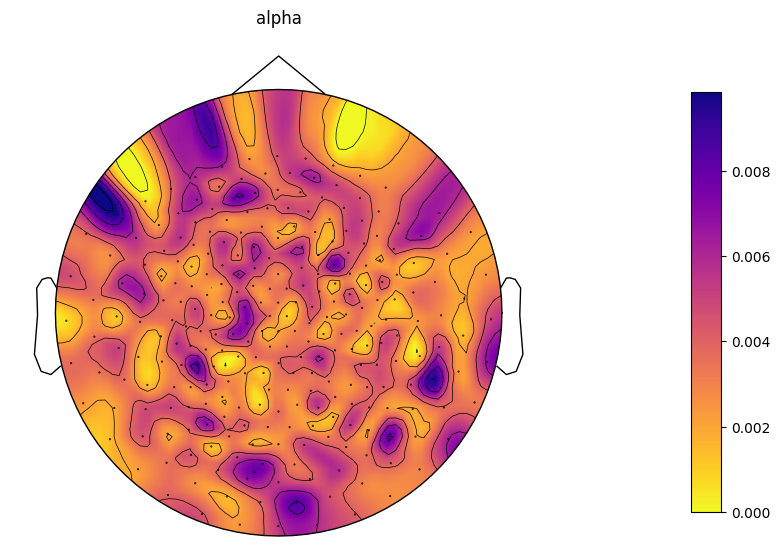

In [20]:
###### PLOT TOPOMAP FEATURE IMPORTANCE ######

# initialize figure
fig, ax_topo = plt.subplots(1, figsize=(30, 6))

for subj in ['all'] :

    for i, freq_name in enumerate(['alpha']): 

        img, _ = mne.viz.plot_topomap(feature_importance, epochs.info, axes=ax_topo, show=False, 
                                      cmap='plasma_r', extrapolate='head',
                                      sphere=(0, 0.0, 0, 0.19))

        ax_topo.set_title(freq_name)    

    # Add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.6, 0.15, 0.01, 0.7])
    fig.colorbar(img, cax=cbar_ax)
    cbar_ax.set_label('Feature importance')

    plt.show()

In [24]:
X = X_subj[-1]
X = X[:, :3]
print(X.shape)

(3240, 3)


In [ ]:
######## PLOT TOPOMAPS ########
for subj in ['all'] :
    sub_name = 'all'
    run_name = 'all'
    tmin_name = str(int(tmin*1000))
    tmax_name = str(int(tmax*1000))
    stage = tmin_name + '-' + tmax_name
    conditions = cond1 + '-' + cond2

    min_list = []
    max_list = []

    # initialize figure
    fig, ax_topo = plt.subplots(1, len(FREQS_NAMES), figsize=(30, 6))

    for i, freq_name in enumerate(FREQS_NAMES): 

        # Load data
        save_scores = RESULT_PATH + 'meg/reports/sub-{}/ml/results_single_feat/sub-{}_task-{}_run-{}_cond-{}_meas-sf-{}_freq_{}{}.pkl'.format(sub_name, sub_name, task, 
                                                                                                                                    run_name, conditions,
                                                                                                                                    'scores-svm', freq_name, stage)
        with open(save_scores, 'rb') as f:
            all_scores = pickle.load(f)

        minimum = np.min(all_scores)
        min_list.append(minimum)

        maximum = np.max(all_scores)
        max_list.append(maximum)



    for i, freq_name in enumerate(FREQS_NAMES): 

        # Load data
        save_scores = RESULT_PATH + 'meg/reports/sub-{}/ml/results_single_feat/sub-{}_task-{}_run-{}_cond-{}_meas-sf-{}_freq_{}{}.pkl'.format(sub_name, sub_name, task, 
                                                                                                                                    run_name, conditions,
                                                                                                                                    'scores-svm', freq_name, stage)
        with open(save_scores, 'rb') as f:
            all_scores = pickle.load(f)

        vmin = min(min_list)
        vmax = max(max_list)

        img, _ = mne.viz.plot_topomap(all_scores, epochs.info, axes=ax_topo[i], show=False, 
                                cmap='plasma_r', extrapolate='head',
                                sphere=(0, 0.0, 0, 0.19), vlim = (0.40, 0.75))

        ax_topo[i].set_title(freq_name)    

    # TODO : put the colorbar on the right
    #cbar = plt.colorbar(
    #    ax=ax_topo[i], shrink=0.2, orientation='vertical', mappable=img,)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(img, cax=cbar_ax)
    cbar_ax.set_label('Accuracy')
    #fig.tight_layout()

    plt.show()